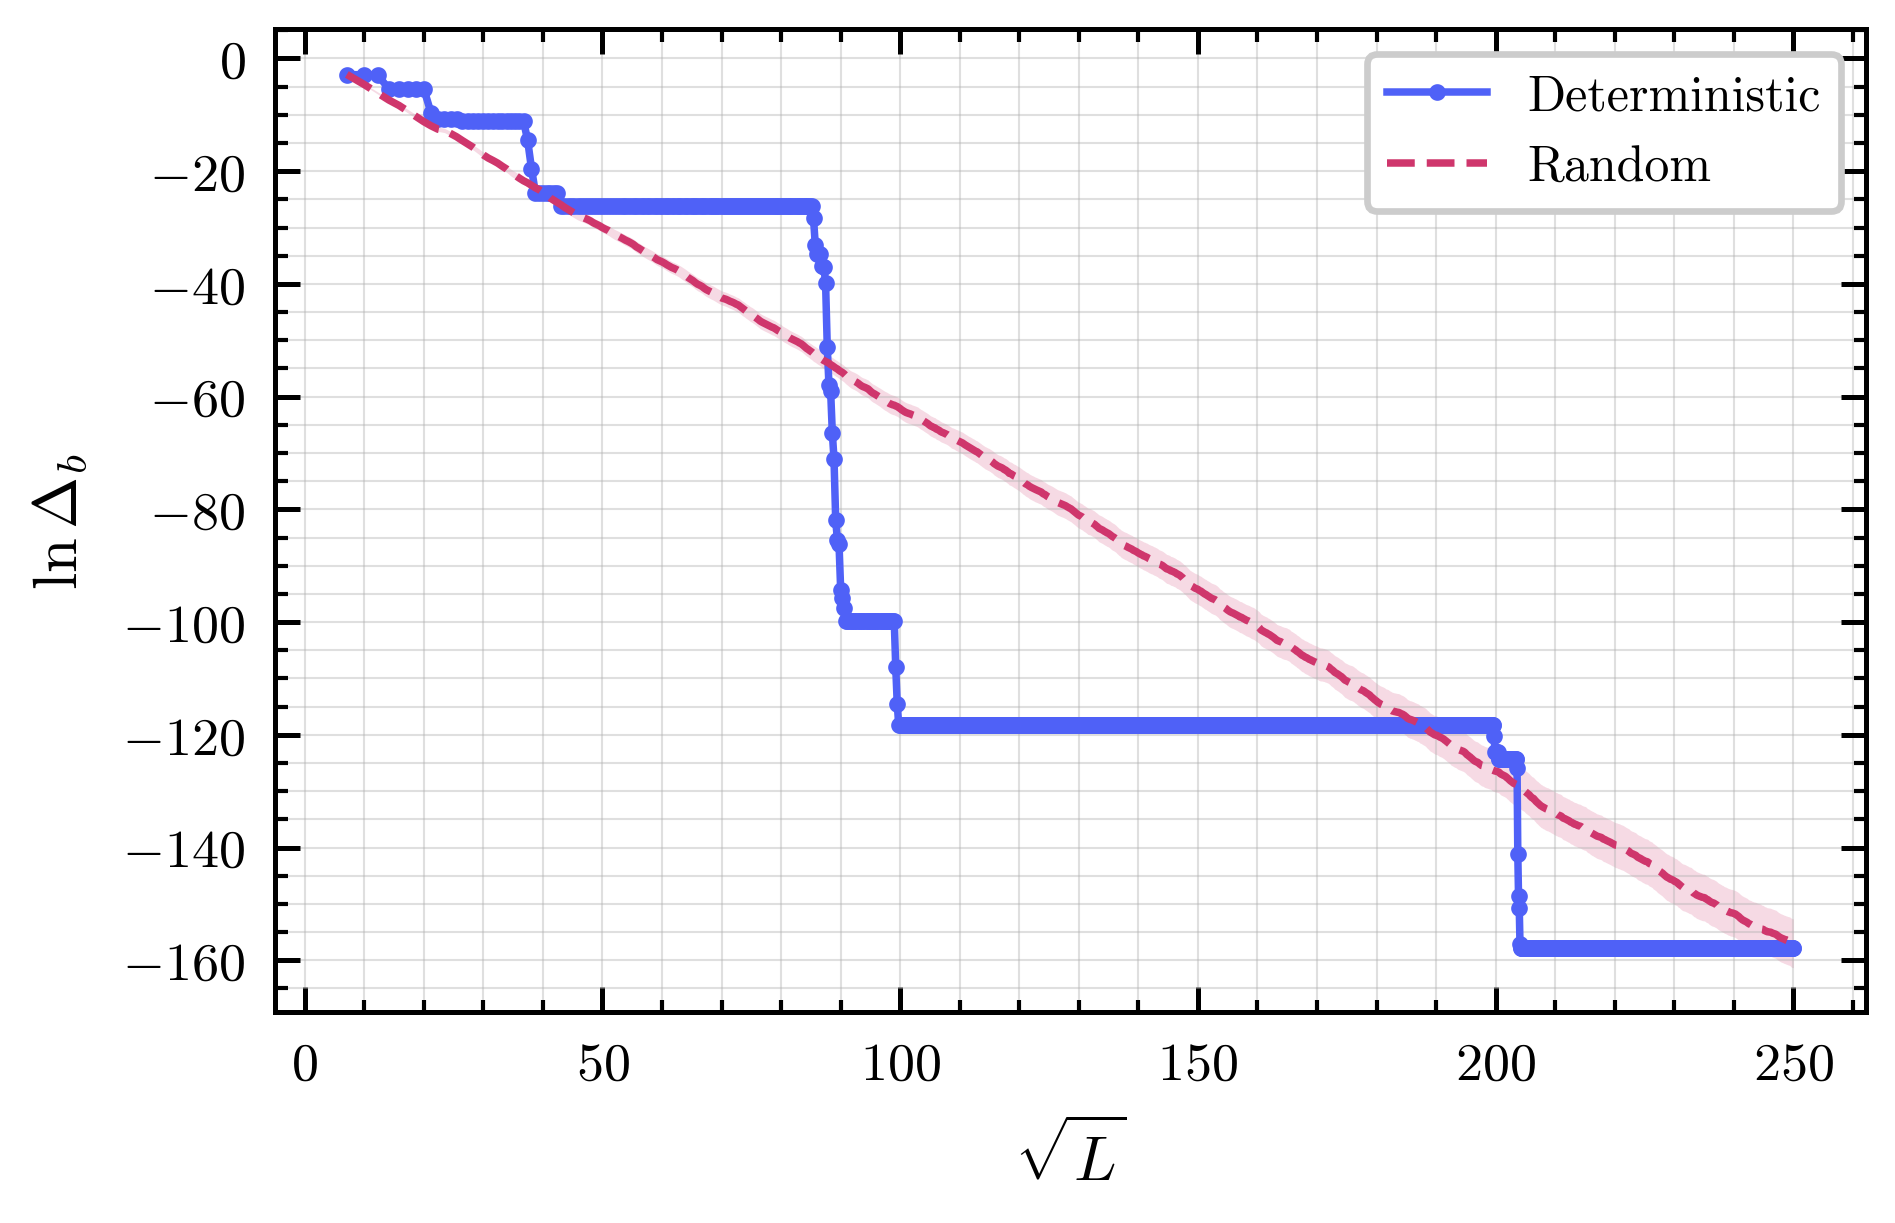

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# -------------------------------------------------------------------
# constants / style
# -------------------------------------------------------------------
FIG_WIDTH_INCH  = 3.4
FIG_HEIGHT_INCH = 3.4 * 0.618

COL_LIGHT = "#4F61F7"  # deterministic
COL_MED   = "#CF366C"  # random RTIM (mean + 99% CI)

DATA_DIR = Path("data_ub/fig3")
DET_FILE = DATA_DIR / "data_deterministic.txt"
RAND_PATTERN = str(DATA_DIR / "data_compare_random_*.txt")

# 99% confidence interval z-value (two-sided)
Z_99 = 2.5758293035489004  # ≈ 2.576

# -------------------------------------------------------------------
# load data
#   format: first line  L (space-separated)
#           second line Delta_b (space-separated)
# -------------------------------------------------------------------
def load_two_line_array(filename):
    with open(filename, "r") as f:
        line1 = f.readline().strip()
        line2 = f.readline().strip()
    L = np.array([float(x) for x in line1.split()])
    Delta_b = np.array([float(x) for x in line2.split()])
    if L.shape != Delta_b.shape:
        raise ValueError(f"L and Delta_b lengths differ in {filename}")
    return L, Delta_b

# deterministic data
L_det, Delta_det = load_two_line_array(DET_FILE)

# random RTIM data (many realizations)
rand_files = sorted(glob.glob(RAND_PATTERN))
if len(rand_files) == 0:
    raise FileNotFoundError(f"No files found for pattern {RAND_PATTERN}")

L_rand_list = []
logDelta_rand_list = []

for fname in rand_files:
    L_tmp, Delta_tmp = load_two_line_array(fname)
    # sanity: all realizations should share the same L grid
    if len(L_rand_list) == 0:
        L_rand = L_tmp
    else:
        if not np.allclose(L_rand, L_tmp):
            raise ValueError("Inconsistent L-grid across random data files.")
    # ensure positive gaps
    if np.any(Delta_tmp <= 0):
        raise ValueError(f"Non-positive Delta_b in {fname}, cannot take log.")
    logDelta_rand_list.append(np.log(Delta_tmp))

logDelta_rand = np.vstack(logDelta_rand_list)   # shape: (N_realizations, N_L)
N_realizations = logDelta_rand.shape[0]

# mean and 99% confidence interval in log space
mean_logDelta = logDelta_rand.mean(axis=0)
std_logDelta  = logDelta_rand.std(axis=0, ddof=1)
stderr_logDelta = std_logDelta / np.sqrt(N_realizations)

half_width_99 = Z_99 * stderr_logDelta
ci_lower_99 = mean_logDelta - half_width_99
ci_upper_99 = mean_logDelta + half_width_99

# deterministic (single sequence) in log space
if np.any(Delta_det <= 0):
    raise ValueError("Non-positive Delta_b in deterministic data, cannot take log.")
logDelta_det = np.log(Delta_det)

x_det = np.sqrt(L_det)
x_rand = np.sqrt(L_rand)

# -------------------------------------------------------------------
# plotting
# -------------------------------------------------------------------
import scienceplots  

with plt.style.context(["science", "ieee", "no-latex"]):
    plt.rcParams.update({
        # fonts (smaller than RevTeX 10pt body text)
        "font.size": 7.5,
        "axes.labelsize": 7.5,
        "axes.titlesize": 7.5,
        "xtick.labelsize": 6.5,
        "ytick.labelsize": 6.5,
        "legend.fontsize": 6,

        # line widths
        "axes.linewidth": 0.6,
        "lines.linewidth": 0.9,
        "lines.markersize": 1,
        "patch.linewidth": 0.8,

        # ticks
        "xtick.major.width": 0.6,
        "ytick.major.width": 0.6,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,

        # grid
        "grid.linewidth": 0.25,
        "grid.alpha": 0.4,

        # legend frame
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.framealpha": 1.0,
    })

    fig, ax = plt.subplots(figsize=(FIG_WIDTH_INCH, FIG_HEIGHT_INCH))

    # deterministic sequence: J_{x,x+1} = sin(x sin x)
    ax.plot(
        x_det, logDelta_det,
        marker="o",
        linestyle="-",
        color=COL_LIGHT,
        label=r"Deterministic",
    )

    # random RTIM: uniform[-1,1], mean ± 99% CI (in log space)
    ax.plot(
        x_rand, mean_logDelta,
        linestyle="--",
        marker=None,
        color=COL_MED,
        label=r"Random",
    )

    ax.fill_between(
        x_rand, ci_lower_99, ci_upper_99,
        color=COL_MED,
        alpha=0.18,
        linewidth=0.0,
        # shaded region: 99% confidence interval
    )

    ax.set_xlabel(r"$\sqrt{L}$")
    ax.set_ylabel(r"$\ln \Delta_b$")

    ax.grid(True, which="both", axis="both")
    ax.legend(loc="best")

    # fairly tight margins for a single-panel, single-column figure
    plt.subplots_adjust(
        left=0.21, right=0.99,
        bottom=0.20, top=0.98
    )

    # save or show
    fig.savefig("figures/fig3.pdf")
    plt.show()
